# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [ ]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

from scipy import io
import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [ ]:
def download_file(file_id, save_path):
    if os.path.exists(save_path):
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2) 데이터 압축 해제

In [ ]:
def dataset_extract(file_name):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        file_list = zip_ref.namelist()

        if os.path.exists(f'/content/{file_name[-14:-4]}/'):
            print(f'파일이 이미 존재합니다.')
            return

        else:
            for f in tqdm(file_list, desc = 'Extracting', unit = 'files' ):
                zip_ref.extract(member = f, path = f'/content/{file_name[-14:-4]}/')

In [ ]:
dataset_extract('/content/drive/MyDrive/KTaivle/4차미니프로젝트/Car_Images.zip의 사본')

Extracting: 100%|██████████| 607/607 [00:11<00:00, 54.89files/s] 


#### 2) 데이터 조회

In [ ]:
# 폴더별 이미지 데이터 갯수 확인
abnormal = '/content/Images.zip/abnormal'
normal = '/content/Images.zip/normal'

print(f'abnormal : {len(os.listdir(abnormal))}')
print(f'normal : {len(os.listdir(normal))}')

abnormal : 303
normal : 302


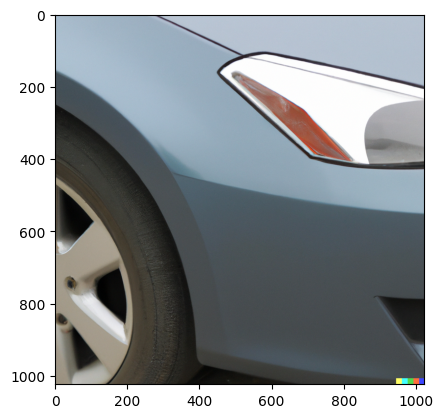

In [ ]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
import random
images = os.listdir(normal)
random_image = random.choice(images)
random_image_path = os.path.join(normal, random_image)
image = plt.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.show()

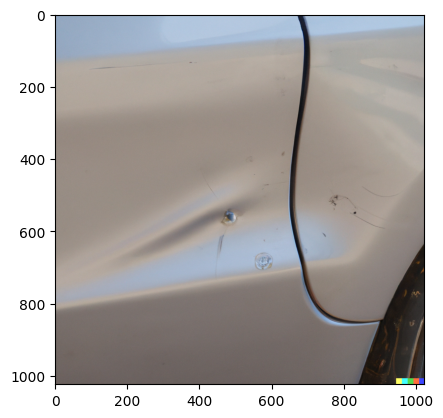

In [ ]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
images = os.listdir(abnormal)
random_image = random.choice(images)
random_image_path = os.path.join(abnormal, random_image)
image = plt.imread(random_image_path)
plt.imshow(image, cmap='gray')
plt.show()

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [ ]:
nor = os.listdir(normal)
abnor = os.listdir(abnormal)
Y_normal = np.zeros(len(nor))
Y_abnormal = np.ones(len(abnor))
Y = np.concatenate([Y_normal, Y_abnormal])
Y.shape

(605,)

In [ ]:
from PIL import Image

nor_images = []
for filename in nor:
    image_path = os.path.join(normal, filename)
    image = Image.open(image_path)
    nor_images.append(image)

abnor_images = []
for filename in abnor:
    image_path = os.path.join(abnormal, filename)
    image = Image.open(image_path)
    nor_images.append(image)

### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [ ]:
X = nor_images + abnor_images

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [ ]:
def images_to_arrays(image_data):
    images_array = []
    for image in image_data:
        image_array = np.array(image)
        images_array.append(image_array)
    return np.array(images_array)

x_train = images_to_arrays(x_train)
x_val = images_to_arrays(x_val)
x_test = images_to_arrays(x_test)

In [ ]:
def resize_images(image_data):
    resized_images = []
    for image in image_data:
        pil_image = Image.fromarray(image)
        resized_image = pil_image.resize((128, 128))
        resized_images.append(np.array(resized_image))
    return np.array(resized_images)

x_train_rs = resize_images(x_train)
x_val_rs = resize_images(x_val)
x_test_rs = resize_images(x_test)

In [ ]:
x_train.shape , x_val.shape, x_test.shape

((489, 1024, 1024, 3), (55, 1024, 1024, 3), (61, 1024, 1024, 3))

In [ ]:
x_train_rs.shape, x_val_rs.shape, x_test_rs.shape

((489, 128, 128, 3), (55, 128, 128, 3), (61, 128, 128, 3))

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [ ]:
import keras
from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPool2D

#### 1) 구조 설계

In [ ]:
model1 = Sequential()

model1.add(Input(shape = (128, 128, 3)))
model1.add(Conv2D(filters = 64,
                   kernel_size = (3, 3),
                   strides = (1, 1),
                   padding = 'same',
                   activation = 'relu',
                   ))
model1.add(Conv2D(filters = 64,
                   kernel_size = (3, 3),
                   strides = (1, 1),
                   padding = 'same',
                   activation = 'relu',
                   ))
model1.add(MaxPool2D(pool_size = (2, 2),
                      strides = (2, 2)
                      ))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 128,
                   kernel_size = (3, 3),
                   strides = (1, 1),
                   padding = 'same',
                   activation = 'relu',
                   ))
model1.add(Conv2D(filters = 128,
                   kernel_size = (3, 3),
                   strides = (1, 1),
                   padding = 'same',
                   activation = 'relu',
                   ))
model1.add(MaxPool2D(pool_size = (2, 2),
                      strides = (2, 2)
                      ))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(512, activation = 'relu'))
model1.add(Dense(2, activation = 'softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,371,330 (257.00 MB)

 Trainable params: 67,370,946 (257.00 MB)

 Non-trainable params: 384 (1.50 KB)

#### 2) 학습

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 3,
                   verbose = 1,
                   restore_best_weights = True)

In [ ]:
model1.fit(x_train_rs, y_train, epochs = 20, verbose = 1,
           validation_data = (x_val_rs, y_val),
           callbacks = [es]
           )

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - accuracy: 0.6729 - loss: 24.4703 - val_accuracy: 0.3455 - val_loss: 299.2666
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8360 - loss: 0.9441 - val_accuracy: 0.6182 - val_loss: 445.5490
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8408 - loss: 0.4622 - val_accuracy: 0.6182 - val_loss: 248.9003
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8523 - loss: 0.3172 - val_accuracy: 0.6545 - val_loss: 140.7268
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8915 - loss: 0.2137 - val_accuracy: 0.6364 - val_loss: 82.7828
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9288 - loss: 0.1256 - val_accuracy: 0.6727 - val_loss: 47.7313
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9680 - loss: 0.0671 - val_accuracy: 0.6727 - val_loss: 24.1730
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9881 - loss: 0.0335 - val_

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [ ]:
pred = model1.predict(x_test_rs)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


In [ ]:
pred1 = np.argmax(pred, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

conf_matrix = confusion_matrix(y_test, pred1)
accuracy = accuracy_score(y_test, pred1)
recall = recall_score(y_test, pred1)
precision = precision_score(y_test, pred1)
f1 = f1_score(y_test, pred1)

print("모델3 성능결과")
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

모델3 성능결과
Confusion Matrix:
[[19 13]
 [ 4 25]]
Accuracy: 0.7213114754098361
Recall: 0.8620689655172413
Precision: 0.6578947368421053
F1 Score: 0.746268656716418


## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/content/Images.zip"

train_data = image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="training",
    seed=1337
    )

val_data = image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.2,
    subset="validation",
    seed=1337
    )

Found 605 files belonging to 2 classes.
Using 484 files for training.
Found 605 files belonging to 2 classes.
Using 121 files for validation.


In [ ]:
class_names = train_data.class_names
print(class_names)

['abnormal', 'normal']


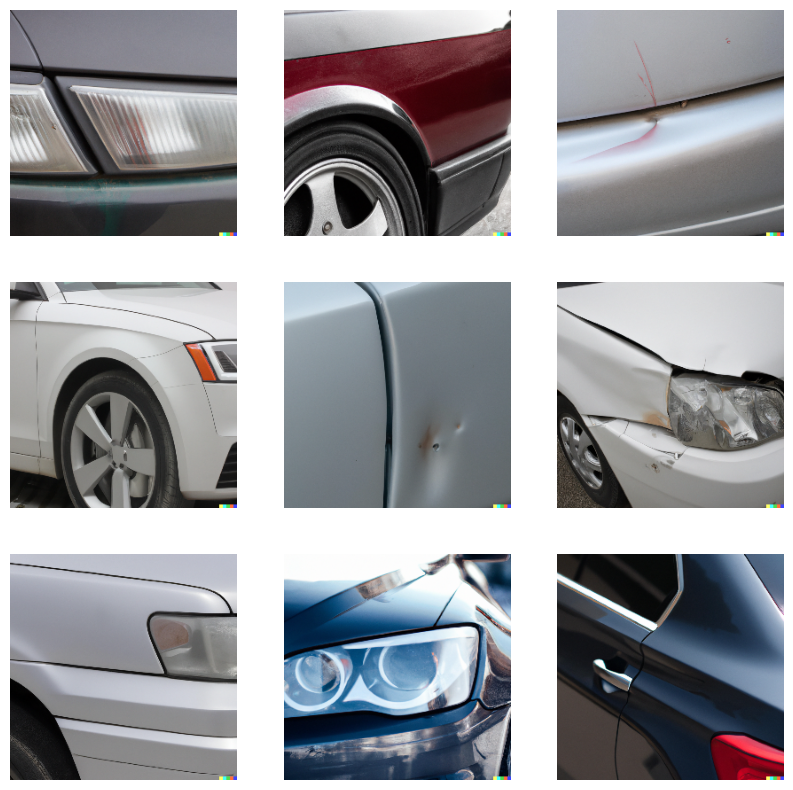

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator를 사용하여 데이터 전처리 및 증강 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 값을 0과 1 사이로 조정
    rotation_range=40,  # 랜덤하게 이미지 회전 (0~40도 범위)
    width_shift_range=0.2,  # 랜덤하게 가로 방향으로 이미지 이동
    height_shift_range=0.2,  # 랜덤하게 세로 방향으로 이미지 이동
    shear_range=0.2,  # 랜덤하게 전단 변환을 적용
    zoom_range=0.2,  # 랜덤하게 이미지 확대/축소
    horizontal_flip=True,  # 랜덤하게 이미지를 수평으로 뒤집기
    fill_mode='nearest'  # 이미지를 회전 또는 이동할 때 채울 방법
)

# 검증 데이터에는 데이터 증강을 적용하지 않음 (오직 전처리만)
val_datagen = ImageDataGenerator(rescale=1./255)

X_train, Y_train = next(iter(train_data))
X_val, Y_val = next(iter(val_data))

# 데이터셋에 데이터 증강을 적용하여 생성
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)

In [ ]:
for i, (X_batch, Y_batch) in enumerate(train_generator):
    print(f"Batch {i+1}:")
    print(f"X_batch shape: {X_batch.shape}")
    print(f"Y_batch shape: {Y_batch.shape}")
    if i >= 4:
      break

for i, (X_batch, Y_batch) in enumerate(val_generator):
    print(f"Batch {i+1}:")
    print(f"X_batch shape: {X_batch.shape}")
    print(f"Y_batch shape: {Y_batch.shape}")
    if i >= 4:
      break

Batch 1:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 2:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 3:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 4:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 5:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 1:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 2:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 3:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 4:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)
Batch 5:
X_batch shape: (32, 256, 256, 3)
Y_batch shape: (32, 2)


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.

In [ ]:
from tensorflow.keras.applications import InceptionV3

Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in Inception_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [ ]:
model = Sequential()

model.add(Input(shape=(256, 256, 3)))
model.add(Inception_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 6, 6, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,677,922 (155.17 MB)

 Trainable params: 18,875,138 (72.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

#### 3) 학습

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.5312 - loss: 1.0890 - val_accuracy: 0.5000 - val_loss: 152.1926
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - accuracy: 0.5625 - loss: 130.0527 - val_accuracy: 0.5000 - val_loss: 59.8775
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - accuracy: 0.5625 - loss: 51.9701 - val_accuracy: 0.5312 - val_loss: 14.0528
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4688 - loss: 16.2878 - val_accuracy: 0.5312 - val_loss: 16.3857
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5312 - loss: 20.3114 - val_accuracy: 0.8125 - val_loss: 4.5990
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0000e+00 - loss:

#### 4) 성능 평가

In [ ]:
y_pred = model.predict(val_generator)

y_pred_binary = (y_pred > 0.5).astype(int)

y_true = val_generator

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [ ]:
y_true

In [ ]:


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
conf_matrix = confusion_matrix(y_true, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1, 32]